## Imports

In [17]:
import os
import time
import copy
from glob import glob
from collections import Counter

In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from PIL import Image
from PIL import ImageFilter
from sklearn.metrics import classification_report, confusion_matrix

## Load data

In [126]:
class RemoveNoise(object):
    def __call__(self, img):
        n = 4
        img = np.array(img)
        am = np.zeros(
            (n, n) + (img.shape[0] - n + 1, img.shape[1] - n + 1) + img.shape[2:],
            dtype = img.dtype
        )
        for i in range(n):
            for j in range(n):
                am[i, j] = img[i:i + am.shape[2], j:j + am.shape[3]]
        am = np.moveaxis(am, (0, 1), (-2, -1)).reshape(*am.shape[2:], -1)
        am = np.median(am, axis = -1)
        if am.dtype != img.dtype:
            am = (am.astype(np.float64) + 10 ** -7).astype(img.dtype)
        # am = img.filter(ImageFilter.BLUR)
        return am

    def __repr__(self):
        return self.__class__.__name__+'()'

In [19]:
data_transforms = {
        'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        # RemoveNoise(),
        # transforms.ToPILImage(),
        transforms.Resize((60,60)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))]),
        'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        # RemoveNoise(),
        # transforms.ToPILImage(),
        transforms.Resize((60,60)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))]),
        'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        # RemoveNoise(),
        # transforms.ToPILImage(),
        transforms.Resize((60,60)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])
     }

In [27]:
data_dir = 'artifacts/train/' # splitted train folder
batch_size = 16
epochs = 15

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)
class_names = np.array(image_datasets['train'].classes)
print('Class name: ', class_names, '\n with number of classes: ', len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

In [130]:
inputs, classes = next(iter(dataloaders['train']))
inputs.size()

torch.Size([16, 1, 60, 60])

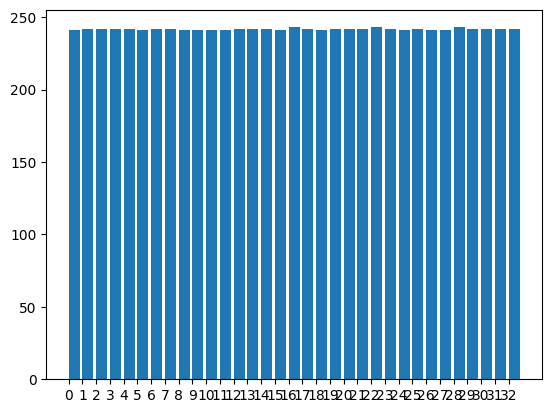

['2' '3' '4' '5' '6' '7' '8' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k'
 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [131]:
train_classes = [label for _, label in image_datasets['train']]
train_dist = dict(Counter(train_classes))
plt.bar(range(len(train_dist)), list(train_dist.values()), align='edge')
plt.xticks(range(len(train_dist)), list(train_dist.keys()))
plt.show()

print(class_names)

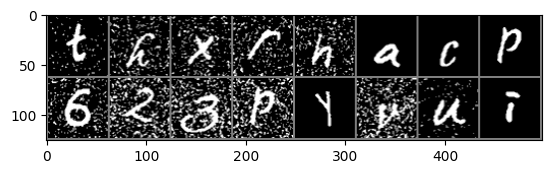

t     h     x     r     h     a     c     p     6     2     3     p     y     v     u     i    


In [132]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

## Define a Convolutional Neural Network



In [133]:
class ClassiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2304, 542)
        self.fc2 = nn.Linear(542, 120)
        self.fc3 = nn.Linear(120, 33)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch 4x2304
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ClassiNet().to(device)

In [134]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=542, bias=True)
  (fc2): Linear(in_features=542, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=33, bias=True)
)

## Define a Loss function and optimizer



In [135]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train the network


In [136]:
start_time = time.time()
best_model_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0

loss_train = []
acc_train = []
loss_val = []
acc_val = []

for epoch in range(epochs):  # loop over the dataset multiple times
    print(f'Epoch {epoch}/{epochs -1}')

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()
        else:
            net.eval()
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            #statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if phase == 'val':
            loss_val.append(epoch_loss)
            acc_val.append(float(epoch_acc))
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
        elif phase == 'train':
            loss_train.append(epoch_loss)
            acc_train.append(float(epoch_acc))

    print('-'*10)

print(f'Finished Training in {time.time() - start_time}')

Epoch 0/14
train Loss: 1.1773 Acc: 0.6514
val Loss: 0.1914 Acc: 0.9383
----------
Epoch 1/14
train Loss: 0.1086 Acc: 0.9668
val Loss: 0.0583 Acc: 0.9820
----------
Epoch 2/14
train Loss: 0.0529 Acc: 0.9862
val Loss: 0.0417 Acc: 0.9843
----------
Epoch 3/14


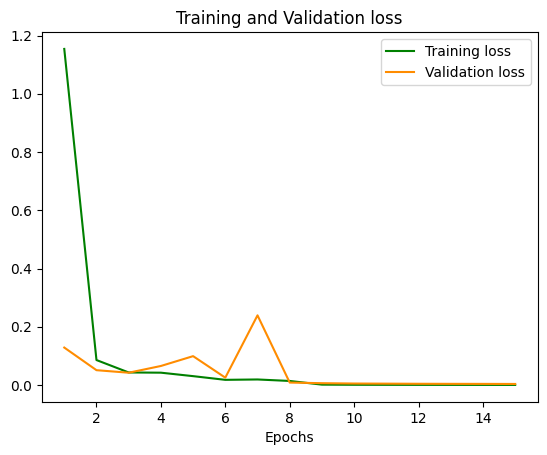

In [ ]:
epochs_plot = range(1, epoch + 2)
plt.plot(epochs_plot, loss_train, 'g', label='Training loss')
plt.plot(epochs_plot, loss_val, 'darkorange', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
plt.show()

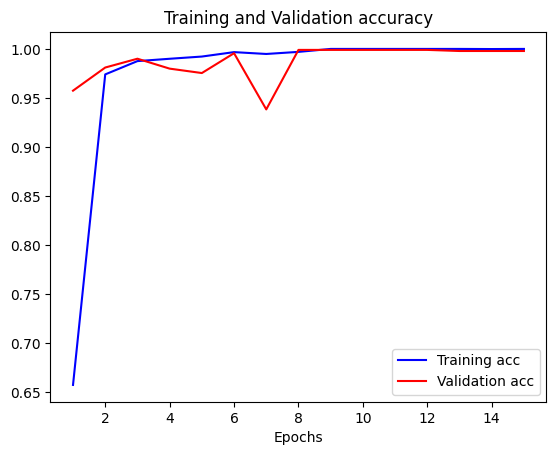

In [ ]:
epochs_plot = range(1, epoch+2)
plt.plot(epochs_plot, acc_train, 'b', label='Training acc')
plt.plot(epochs_plot, acc_val, 'r', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('')
plt.legend()
plt.show()

## Save the model

In [ ]:
PATH = 'artifacts/model/correted_21_0102_best.pth'
torch.save(net.state_dict(), PATH)

## Test the network on the test data

In [ ]:
net = ClassiNet()
net.load_state_dict(torch.load(PATH))
net.eval()

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
)

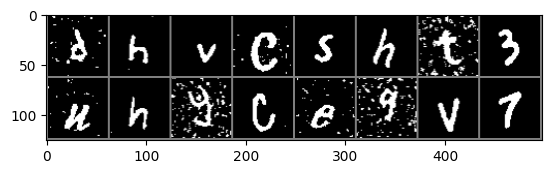

GroundTruth:  d     h     v     c    
Predicted:  d     h     v     c    
tensor([[-9.2137e+00, -9.7461e+00, -1.2992e+01, -3.4514e+01, -1.7132e+01,
         -2.6603e+01, -1.8479e+01, -1.2947e+01, -2.1544e+00, -1.0563e+01,
          9.2962e+00, -1.5727e+01, -1.8664e+01, -9.2391e+00, -1.3371e+01,
         -4.5666e+00,  2.8758e-01, -9.7618e+00, -5.5909e+00, -2.8894e+01,
         -2.8267e+01, -1.0971e+01, -2.6835e+01, -1.6146e+01, -2.1769e+01,
         -8.7824e+00, -1.5932e+01, -1.4230e+01, -1.1048e+01, -1.8274e+01,
         -1.9529e+01, -9.7256e+00, -1.5979e+01],
        [-2.0950e+01, -3.5508e+01, -2.1707e+01, -4.3289e+00, -1.1323e+01,
         -2.7067e+01, -1.2940e+01, -1.8571e+01,  6.4364e+00, -8.8925e+00,
         -1.7251e+01, -1.0443e+01, -8.2494e+00, -1.4477e+01,  1.5582e+01,
         -1.3197e+01, -1.6363e+01,  1.8179e-01, -1.4751e+01, -2.1391e+01,
         -3.1162e+00, -1.6754e+01, -1.8133e+01, -1.3627e+01, -1.6183e+00,
         -1.6501e+01, -2.4025e+01, -1.6804e+01, -2.8703e+00, -1

In [ ]:
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(4)))
# print(outputs)

In [ ]:
correct = 0
total = 0

predictions = []
y_labels = []

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # get list to make reports
        predictions.extend(predicted.tolist())
        y_labels.extend(labels.tolist())

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


Accuracy of the network on the 10000 test images: 99 %


In [ ]:
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
print(classification_report(y_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        34
           4       0.97      1.00      0.99        34
           5       1.00      1.00      1.00        33
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        34
           8       1.00      1.00      1.00        33
           a       1.00      1.00      1.00        34
           b       0.97      1.00      0.99        34
           c       1.00      1.00      1.00        34
           d       1.00      1.00      1.00        33
           e       1.00      1.00      1.00        34
           f       1.00      0.97      0.99        34
           g       1.00      1.00      1.00        34
           h       1.00      0.97      0.99        34
           i       1.00      1.00      1.00        34
           j       1.00      1.00      1.00        34
           k       1.00    

<Axes: >

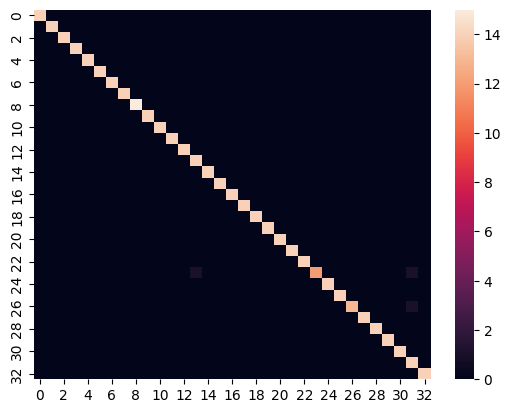

In [ ]:
sns.heatmap(confusion_matrix(y_labels, predictions))